# 15章 3节 拖拉机销售数据预测

## 1 数据整理

In [1]:
import warnings
import itertools

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\ben\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
sales_data = pd.read_csv('tractor_sales.csv')
sales_data.head(2)

,Month-Year,Number of Tractor Sold
0,3-Jan,141
1,3-Feb,157


In [3]:
# since the complete date was not mentioned, we assume that it was the first of every month
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(sales_data))

In [4]:
import calendar
sales_data['Month'] = dates.month
sales_data['Month'] = sales_data['Month'].apply(lambda x: calendar.month_abbr[x])
sales_data['Year'] = dates.year

In [5]:
sales_data.drop(['Month-Year'], axis=1, inplace=True)
sales_data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)
sales_data = sales_data[['Month', 'Year', 'Tractor-Sales']]

In [6]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
sales_data.set_index(dates, inplace=True)

In [7]:
# check out first 5 samples of the data
sales_data.head(5)

,Month,Year,Tractor-Sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203


In [8]:
# extract out the time-series
sales_ts = sales_data['Tractor-Sales']

Text(0,0.5,'Tractor Sales')

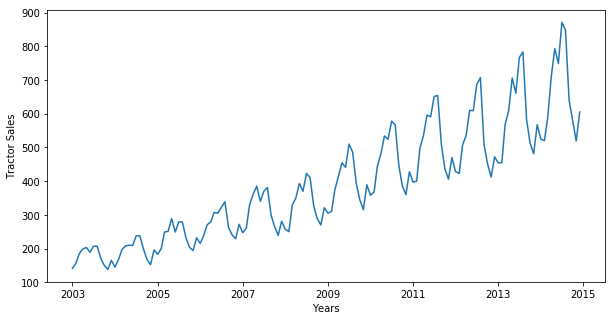

In [9]:
sales_data = pd.read_csv('tractor_sales.csv')
plt.figure(figsize=(10, 5))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

## 2 趋势分解

In [ ]:
#decomposition = sm.tsa.seasonal_decompose(sales_ts, model='multiplicative')
#fig = decomposition.plot()
#fig.set_figwidth(12)
#fig.set_figheight(8)
#fig.suptitle('Decomposition of multiplicative time series')
#plt.show()

## 3 构建ARIMA

- 3.1 进行必要的数值转换

Text(0,0.5,'Log (Tractor Sales)')

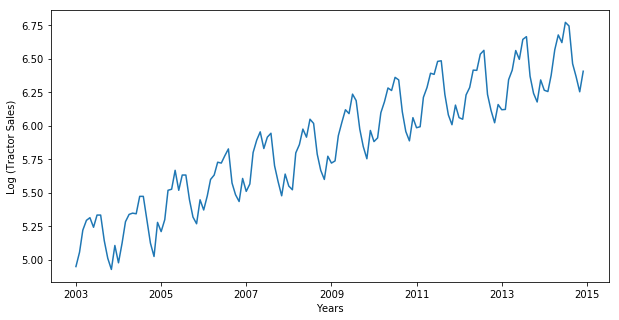

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(np.log(sales_ts))
plt.xlabel('Years')
plt.ylabel('Log (Tractor Sales)')

- 3.2 选择合适的差分阶数

Text(0,0.5,'Differenced Log (Tractor Sales)')

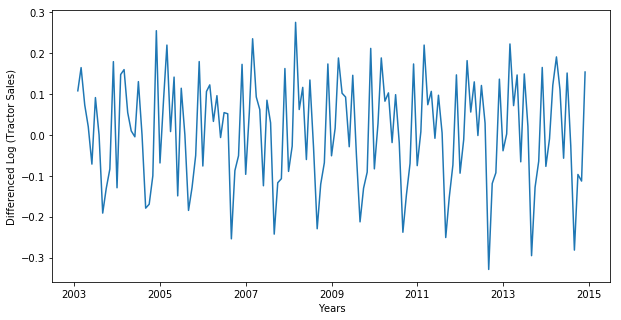

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(np.log(sales_ts).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Tractor Sales)')

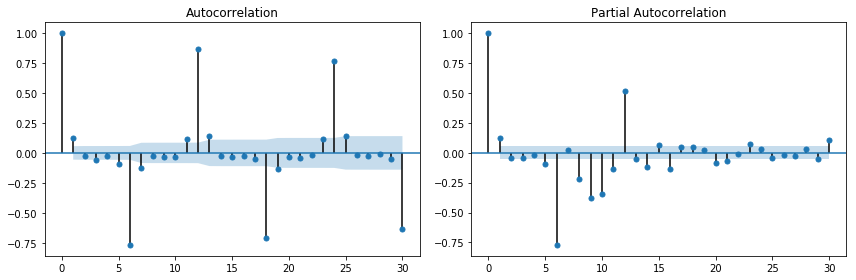

In [12]:
sales_ts_log = np.log(sales_ts)
sales_ts_log.dropna(inplace=True)

sales_ts_log_diff = sales_ts_log.diff(periods=1) 
sales_ts_log_diff.dropna(inplace=True)

fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log_diff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_ts_log_diff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

- 3.3 确定参数

In [ ]:
# 设置自相关(AR)、差分(I)、移动平均(MA)的三个参数的取值范围
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
# 设置季节效应的自相关(AR)、差分(I)、移动平均(MA)的三个参数的取值范围
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
import sys
warnings.filterwarnings("ignore") # 忽略ARIMA模型无法估计出结果时的报警信息
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

In [13]:
best_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                      order=(0, 1, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()

In [ ]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

- 3.4 对残差进行检验

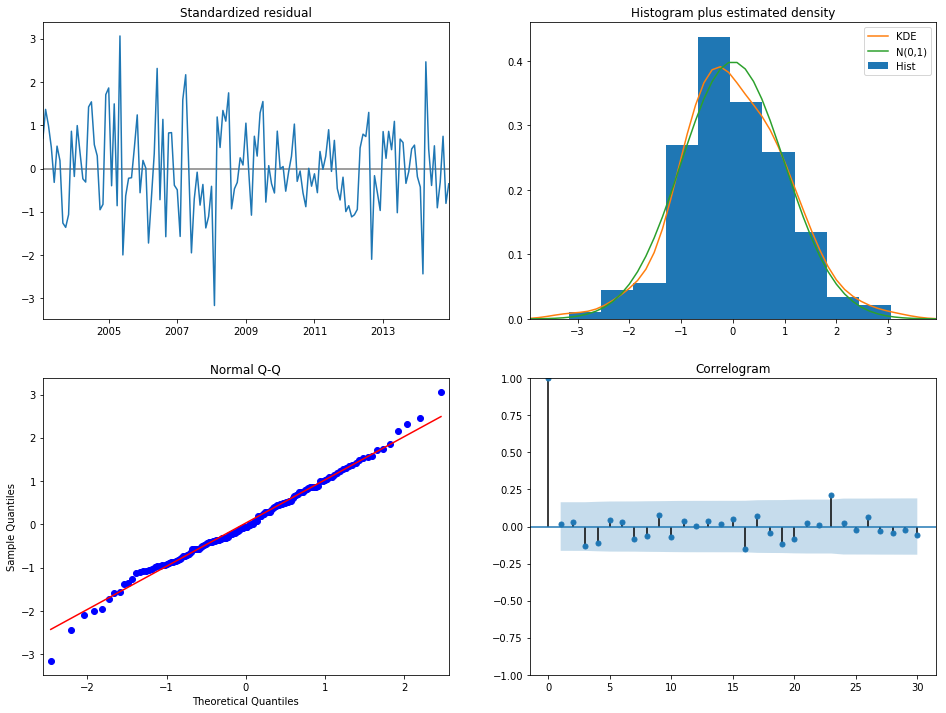

In [16]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

- 3.5 进行预测

In [17]:
#pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)
#pred_dynamic_ci = pred_dynamic.conf_int()
#sales_ts_forecasted = pred_dynamic.predicted_mean
#sales_ts_truth = sales_ts_log['2012-01-01':]

In [18]:
#import math
#axis = sales_ts['2005':].plot(label='Observed', figsize=(10, 6))
#np.power(math.e, pred_dynamic.predicted_mean).plot(ax=axis, label='Dynamic Forecast', alpha=0.7)
#axis.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
#axis.fill_betweenx(axis.get_ylim(), pd.to_datetime('2012-01-01'), sales_ts.index[-1], alpha=.1, zorder=-1)
#axis.set_xlabel('Years')
#axis.set_ylabel('Tractor Sales')
#plt.legend(loc='best')
#plt.show()
#plt.close()

In [29]:
import math
n_steps = 36
pred_uc_95 = best_results.get_forecast(steps=n_steps, alpha=0.05) 
pred_pr_95=pred_uc_95.predicted_mean
pred_ci_95 = pred_uc_95.conf_int()
idx = pd.date_range(sales_ts.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(math.e, pred_pr_95), 
                                      np.power(math.e, pred_ci_95)]), index=idx,
                               columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_95.head(2)

,forecast,lower_ci_95,upper_ci_95
2014-12-01,567.460865,528.210592,609.627748
2015-01-01,566.199249,519.952771,616.559057


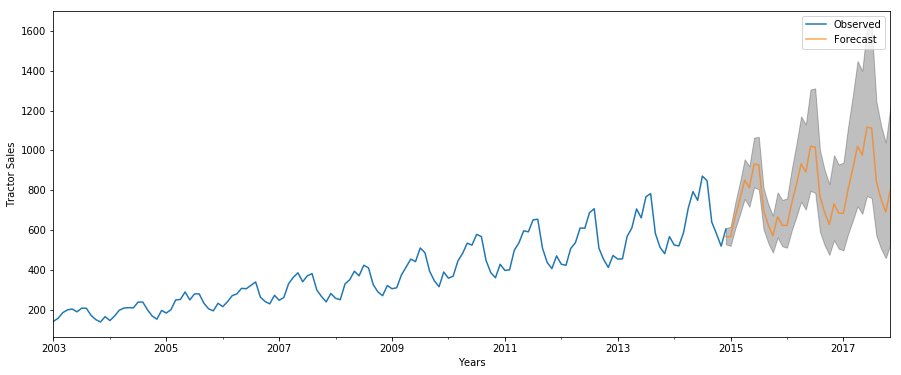

In [28]:
axis = sales_ts.plot(label='Observed', figsize=(15, 6))
fc_95['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_95['lower_ci_95'], fc_95['upper_ci_95'], 
                  color='k', alpha=.25)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()